# desilike

## Framework to specify DESI (clustering) likelihoods

### Tutorial #2: bindings with external inference codes

# Goals
At the end of the tutorial you will know:
- how to write likelihoods in terms of compressed parameters (e.g. based on forecasts), optionally with covariance between different measurements
- how to write full shape likelihoods, and emulate their theory
- how to run inference within desilike, or [Cobaya](https://github.com/CobayaSampler/cobaya), [CosmoSIS](https://github.com/joezuntz/cosmosis), and [MontePython](https://github.com/brinckmann/montepython_public).

For real-life examples, see the application to [mock Y1 cosmological inference](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_y1).

This is the continuation of the first tutorial, accessible here: https://github.com/cosmodesi/desilike-tutorials.

# Environment

Easiest is to use the cosmodesi environment at NERSC:
```
source /global/common/software/desi/users/adematti/cosmodesi_environment.sh main  # source the environment
${COSMODESIMODULES}/install_jupyter_kernel.sh main  # this to be done once
```
NB: to remove the previous kernel:
```
rm -rf ${HOME}/.local/share/jupyter/kernels/cosmodesi-main
```
To see these slides in a browser, e.g.:
```
firefox desilike_bindings.slides.html
```

# Compressed likelihoods

Let's first focus on compressed likelihoods = only depend on the cosmological model (nuisance = bias, stochastic and counterterms already marginalized out).

=> sampling of these likelihoods is typically fast enough that they do not need to be emulated.

## BAO likelihood

BAO likelihoods are built from a "BAO observable", that compares a data vector to a theory, typically $\alpha_{\perp}$ and $\alpha_{\parallel}$ or $D_{M}/r_{d}$ and $D_{H}/r_{d}$.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import jax; jax.config.update('jax_platform_name', 'cpu')

In [2]:
import numpy as np

from desilike import utils, setup_logging
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.observables.galaxy_clustering import BAOCompressionObservable

setup_logging()

# fiducial cosmology is DESI's by default
observable1 = BAOCompressionObservable(data=[1., 1.],
                                       covariance=np.diag([0.01, 0.01]),
                                       quantities=['qpar', 'qper'],
                                       z=1.)
# Let's define the likelihood from this observable
likelihood = ObservablesGaussianLikelihood(observable1)

### Reminder

In [3]:
# Likelihood parameters
print('varied likelihood parameters are', likelihood.varied_params.names())
# To evaluate the likelihood (return the logposterior)
print('logposterior is {:.3f}'.format(likelihood(Omega_m=0.29)))

[000000.13] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
varied likelihood parameters are ['Omega_m']
logposterior is -0.005


Why do we bother about "observables"?

... because we can join them in a likelihood!

In [4]:
# We want to share the same cosmological calculation among all observables
# so let's give it explicitly
from desilike.theories import Cosmoprimo
cosmo = Cosmoprimo(fiducial='DESI')
# Set Cosmoprimo calculator's parameters
cosmo.init.params = {'Omega_m': {'prior': {'limits': [0.1, 0.9]},
                                 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.002},
                                 'latex': '\Omega_m'}}
# Let's reuse the first observable we have defined, just updating the cosmo
observable1.init.update(cosmo=cosmo)
# Let's be fancy and rather define our observable in terms of DV_over_rd
# We provide a dictionary to "data": the theory vector will be generated automatically
observable2 = BAOCompressionObservable(data={}, quantities=['DV_over_rd'], z=1.5, cosmo=cosmo)
# Let's join the two observables, and provide the joint covariance
likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                           covariance=np.diag([0.01, 0.01, 1.]))
print('likelihood is {:.4f}'.format(likelihood()))

[000000.89] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000001.44] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['DV_over_rd'].
likelihood is -0.0000


We can also sum (log-) likelihoods!

In [5]:
likelihood2 = likelihood + likelihood
likelihood(Omega_m=0.29)
likelihood2(Omega_m=0.29)
assert np.allclose(likelihood2.loglikelihood, 2. * likelihood.loglikelihood)

## Bindings
To generate desilike bindings, let's start by writing a callable (~ "function") that returns the desilike likelihood.

In [6]:
def BAOLikelihood(cosmo='external'):
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    # = by the external cosmological inference code
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5,
                                           cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

### Cobaya
### 'Dynamic' bindings

Cobaya is built such that we can provide likelihoods defined on-the-fly (i.e. not in a Python script), and run inference from Python directly.

In [7]:
from desilike.bindings.cobaya import CobayaLikelihoodFactory

# CobayaBAOLikelihood is a Cobaya Likelihood object
CobayaBAOLikelihood = CobayaLikelihoodFactory(BAOLikelihood, params=True)

[000002.17] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000002.26] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000002.72] [0/1] 01-14 08:14  numexpr.utils             INFO     NumExpr defaulting to 8 threads.


In [8]:
from cosmoprimo.fiducial import DESI
cosmo = DESI()

# No magic here, this is all Cobaya stuff
params = {'Omega_m': {'prior': {'min': 0.1, 'max': 1.},
                      'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
                      'latex': '\Omega_{m}'}}
params.update({name: float(cosmo[name]) for name\
               in ['omega_b', 'H0', 'A_s', 'n_s', 'tau_reio']})

info = {'params': params,
        'likelihood': {'bao_likelihood': CobayaBAOLikelihood},
        'theory': {'classy': {'extra_args': {'N_ncdm': cosmo['N_ncdm'], 'N_ur': cosmo['N_ur']}}}}

from cobaya.model import get_model
model = get_model(info)
model.logposterior({'Omega_m': cosmo['Omega_m']})

[000003.12] [0/1] 01-14 08:14  classy                    INFO     `classy` module loaded successfully from /local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/classy-3.2.2-py3.10-linux-x86_64.egg
[000003.23] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000003.33] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000003.70] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000003.79] [0/1] 01-14 08:14  BAOCompressionObservable  INFO     Found quantities ['qiso'].


LogPosterior(logpost=0.1046440231232537, logpriors=[0.10536051565782628], loglikes=array([-0.00071649]), derived=[-0.0007164925345725844, 0.0], finite=False)

In [9]:
# Let's run MCMC!
info_sampler = {'mcmc': {'Rminus1_stop': 0.01, 'seed': 42}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model)
mcmc.run()

[000007.86] [0/1] 01-14 08:14  mcmc                      WARNING  This run has been SEEDED with seed 42
[000007.87] [0/1] 01-14 08:14  mcmc                      INFO     Getting initial point... (this may take a few seconds)
[000007.98] [0/1] 01-14 08:14  mcmc                      INFO     Initial point: Omega_m:0.3041833
[000007.98] [0/1] 01-14 08:14  model                     INFO     Measuring speeds... (this may take a few seconds)
[000008.30] [0/1] 01-14 08:14  model                     INFO     Setting measured speeds (per sec): {bao_likelihood: 271.0, classy: 9.74}
[000008.30] [0/1] 01-14 08:14  mcmc                      INFO     Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[000008.31] [0/1] 01-14 08:14  mcmc                      INFO     Sampling!
[000008.43] [0/1] 01-14 08:14  mcmc                      INFO     Progress @ 2025-01-14 08:14:35 : 1 steps taken, and 0 accepted.
[000012.69]

[000164.27] [0/1] 01-14 08:17  root                      WARNING  outlier fraction 0.09318181818181819 


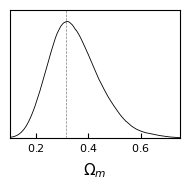

In [10]:
from getdist.mcsamples import MCSamplesFromCobaya
samples_bao_cobaya = mcmc.samples(combined=True, skip_samples=0.5, to_getdist=True).copy(label='cobaya')
from getdist import plots
g = plots.get_subplot_plotter()
g.triangle_plot(samples_bao_cobaya, params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### Interlude: let's do the same within desilike

In [11]:
from desilike.samplers import MCMCSampler

from desilike.theories import Cosmoprimo
cosmo = Cosmoprimo(fiducial='DESI')
# Set Cosmoprimo calculator's parameters
cosmo.init.params = {'Omega_m': {'prior': {'limits': [0.1, 1.]},
                                 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
                                 'latex': '\Omega_m'}}
sampler = MCMCSampler(BAOLikelihood(cosmo=cosmo), seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.01, 'stable_over': 2}, check_every=40)
# do help(chains[0]) to get info on the available methods!
samples_bao_desilike = chains[0].remove_burnin(0.5).to_getdist(label='desilike')

[000165.11] [0/1] 01-14 08:17  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000165.19] [0/1] 01-14 08:17  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000165.56] [0/1] 01-14 08:17  MCMCSampler               INFO     Varied parameters: ['Omega_m'].
[000166.77] [0/1] 01-14 08:17  BasePipeline              INFO     Found speeds:
[000166.77] [0/1] 01-14 08:17  BasePipeline              INFO     - <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x74b275147f10>: 65.23 iterations / second - 0.015 s / iteration
[000166.77] [0/1] 01-14 08:17  BasePipeline              INFO     - <desilike.theories.galaxy_clustering.power_template.BAOExtractor object at 0x74b2754c5150>: 11.15 iterations / second - 0.090 s / iteration
[000166.77] [0/1] 01-14 08:17  BasePipeline              INFO     - <desilike.observables.galaxy_clustering.compression.BAOCompressionObservable object at 0x74b2754b0910>: 3516.06 iterations / second - 0.000 s / iteration
[000

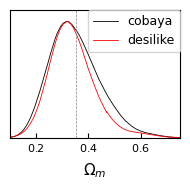

In [12]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### 'Static' bindings

Other inference codes (CosmoSIS, MontePython) typically require the likelihood to be written down in a file,
such that it is imported by the code.
Let's illustrate this, still with Cobaya.

In [13]:
!rm -rf _tests

In [14]:
utils.mkdir('_tests')

In [15]:
%%file _tests/bao_likelihood.py

dirname = '.'

def BAOLikelihood(cosmo='external'):
    import numpy as np
    from desilike.observables.galaxy_clustering import BAOCompressionObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator
    # We could provide a list of Likelihoods, which will all be written at once
    CobayaLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})

Writing _tests/bao_likelihood.py


Let's generate the static bindings by calling the above Python script

In [16]:
%%bash
cd _tests/
python bao_likelihood.py

Let's take a look at the generated files:
- the Python module containing the Cobaya likelihood: ``bao_likelihood.py``
- imported in the ``__init__.py``
- the ``.yaml`` config file containing the nuisance parameters (none in this case)

In [17]:
!ls -la _tests/cobaya_bindings

total 20
drwxr-xr-x 2 adematti idphp 4096 janv. 14 08:17 .
drwxr-xr-x 3 adematti idphp 4096 janv. 14 08:17 ..
-rw-r--r-- 1 adematti idphp  514 janv. 14 08:17 bao_likelihood.py
-rw-r--r-- 1 adematti idphp  158 janv. 14 08:17 BAOLikelihood.yaml
-rw-r--r-- 1 adematti idphp   30 janv. 14 08:17 __init__.py


In [18]:
!cat _tests/cobaya_bindings/BAOLikelihood.yaml

stop_at_error: true
ignore_unknown_cosmoprimo_params: true
params:
  loglikelihood:
    latex: L
    derived: true
  logprior:
    latex: p
    derived: true


Now let's write the config file to run inference. This is pure Cobaya.

In [19]:
%%file _tests/config_bao.yaml

theory:
  classy:
    extra_args:
      N_ncdm: 1
      N_ur: 2.0328

likelihood:
  cobaya_bindings.bao_likelihood.BAOLikelihood:
      python_path: _tests

params:
  Omega_m:
    prior:
      min: 0.1
      max: 1.
    ref:
      dist: norm
      loc: 0.3
      scale: 0.01
    latex: \Omega_{m}
  omega_b: 0.02237
  H0: 67.36
  As: 2.083e-09
  n_s: 0.9649
  tau_reio: 0.0544

sampler:
  mcmc:
    Rminus1_stop: 0.01
    seed: 42

debug: False

output: _tests/chains_bao_cobaya/chain


Writing _tests/config_bao.yaml


Let's sample!

In [20]:
!cobaya-run _tests/config_bao.yaml

/local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[output] Output to be read-from/written-into folder '_tests/chains_bao_cobaya', with prefix 'chain'
[jax._src.xla_bridge] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[jax._src.xla_bridge] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[classy] `classy` module loaded successfully from /local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/classy-3.2.2-py3.10-linux-x86_64.egg
[BAOCompressionObservable] Found quantities ['qpar', 'qper'].
[BAOCompressionObservable] Found quantities ['qiso'].
[BAOCompressionObservable] Found qua

[000399.43] [0/1] 01-14 08:21  root                      WARNING  outlier fraction 0.09318181818181819 


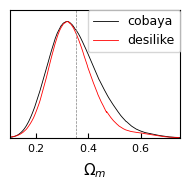

In [21]:
# To load Cobaya samples from disk
from getdist.mcsamples import loadMCSamples
samples_bao_cobaya = loadMCSamples('_tests/chains_bao_cobaya/chain', settings={'ignore_rows': 0.5}).copy(label='cobaya')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### CosmoSIS
Let's apply the static bindings to CosmoSIS.
The BAOLikelihood definition is exactly the same, we just need to generate new files with a simple CosmoSISLikelihoodGenerator call.

In [22]:
%%file _tests/bao_likelihood.py

dirname = '.'

# The same as for Cobaya!
def BAOLikelihood(cosmo='external'):
    import numpy as np
    from desilike.observables.galaxy_clustering import BAOCompressionObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})
    # The only change!
    CosmoSISLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})
    # Let's directly generate the bindings for MontePython
    MontePythonLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})

Overwriting _tests/bao_likelihood.py


Let's generate the static bindings by calling the above Python script

In [23]:
%%bash
cd _tests
python bao_likelihood.py

Let's take a look at the generated files:
- the likelihood module: ``BAOLikelihood.py``
- the ``*values.ini`` file containing the values / ranges of nuisance parameters (none in this case), to be copy-pasted in the input ``*values.ini`` (see below)
- the ``*priors.ini`` file containing the optional priors of nuisance parameters, to be copy-pasted in the input ``*priors.ini`` file

In [24]:
ls -la _tests/cosmosis

ls: impossible d'accéder à '_tests/cosmosis': Aucun fichier ou dossier de ce nom


Now let's write the config file to run inference. This is pure CosmoSIS.

In [25]:
%%file _tests/config_bao.ini

[DEFAULT]
fatal_errors = T

[runtime]
sampler = emcee

[output]
filename = _tests/chains_bao_cosmosis/chain.txt
format = text
verbosity = 0

[pipeline]
modules = consistency camb bao
values = _tests/values_bao.ini
likelihoods = BAOLikelihood  ; notice the name of the likelihood: the same as the *.py file
quiet = T
debug = F
timing = F

[consistency]
file = ${COSMOSIS_STD_DIR}/utility/consistency/consistency_interface.py

[camb]
file = ${COSMOSIS_STD_DIR}/boltzmann/camb/camb_interface.py
mode = background
feedback = 0
nz = 901

[bao]
file = _tests/cosmosis_bindings/BAOLikelihood.py

[emcee]
walkers = 6
samples = 600
nsteps = 20

Writing _tests/config_bao.ini


The ``*values.ini`` file containing parameter values and ranges

In [26]:
%%file _tests/values_bao.ini

[cosmological_parameters]
; This is the only parameter being varied.
omega_m = 0.1 0.3 0.9
ombh2 = 0.02237
h0 = 0.6736
A_s = 2.083e-09
n_s = 0.9649
tau = 0.0544

mnu = 0.06
nnu = 3.046
num_massive_neutrinos = 1
omega_k = 0.0
w = -1.0
wa = 0.0

Writing _tests/values_bao.ini


Let's sample!

In [27]:
!cosmosis _tests/config_bao.ini

Deprecated: The [pipeline] quiet option is deprecated.  Set [runtime] verbosity instead.
Setting up pipeline from parameter file _tests/config_bao.ini
-------------------------------------------------------------

Setting up module consistency
------------------------------

Setting up module camb
-----------------------

Setting up module bao
----------------------
Setup all pipeline modules


Parameter Priors
----------------
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--ombh2                  ~ delta(0.02237)
cosmological_parameters--h0                     ~ delta(0.6736)
cosmological_parameters--a_s                    ~ delta(2.083e-09)
cosmological_parameters--n_s                    ~ delta(0.9649)
cosmological_parameters--tau                    ~ delta(0.0544)
cosmological_parameters--mnu                    ~ delta(0.06)
cosmological_parameters--nnu                    ~ delta(3.046)
cosmological_parameters--num_massive_neutrinos  ~ delta(1

LOADING CHAIN FROM FILE:  _tests/chains_bao_cosmosis/chain.txt


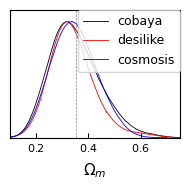

In [28]:
# To load CosmoSIS samples from disk
from cosmosis import Inifile
from cosmosis.output import input_from_options
from getdist import MCSamples

ini = Inifile('_tests/config_bao.ini')
options = dict(ini.items('output'))
options['filename'] = '_tests/chains_bao_cosmosis/chain.txt'
column_names, data = input_from_options(options)[:2]
#print(column_names)
data = data[0].T
data = data[..., data.shape[-1] // 2::10]  # removing burnin and thinning
samples_bao_cosmosis = MCSamples(samples=[data[0]], weights=None, loglikes=-data[-1],
                                 names=['Omega_m'], label='cosmosis')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike, samples_bao_cosmosis],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### MontePython

MontePython is not a Python package, so is not installed in the cosmodesi environment.

Let's install it locally! (it may take some time to download, because of the data sets).

In [29]:
%%bash
cd _tests/
git clone https://github.com/brinckmann/montepython_public.git

Clonage dans 'montepython_public'...
Mise à jour des fichiers: 100% (1511/1511), fait.


We write the ``.conf`` file that specifies the path to the Boltzman code Class and Planck likelihoods.

In [30]:
%%file _tests/montepython_public/default.conf

import os
path['cosmo'] = os.getenv('CLASS_STD_DIR')
path['clik'] = os.path.join(os.getenv('PLANCK_SRC_DIR'), 'code', 'plc_3.0', 'plc-3.1')

Writing _tests/montepython_public/default.conf


Let's take a look at the files previously generated by the static bindings:

- the package: ``BAOLikelihood``
- with a (mandatory) ``*.data`` file specifying the likelihood name and nuisance parameter priors
- with ``*.param`` file specifying parameter ranges, to be copy-pasted in the input ``.param`` file (see below)
- with the ``__init__.py`` file containing the likelihood definition

As required by MontePython, we copy all this to the ``montepython/likelihoods`` directory.

In [31]:
!ls -la _tests/montepython_bindings/BAOLikelihood
!cp -r _tests/montepython_bindings/BAOLikelihood _tests/montepython_public/montepython/likelihoods/

total 20
drwxr-xr-x 2 adematti idphp 4096 janv. 14 08:21 .
drwxr-xr-x 3 adematti idphp 4096 janv. 14 08:21 ..
-rw-r--r-- 1 adematti idphp   35 janv. 14 08:21 BAOLikelihood.data
-rw-r--r-- 1 adematti idphp   52 janv. 14 08:21 BAOLikelihood.param
-rw-r--r-- 1 adematti idphp  523 janv. 14 08:21 __init__.py


Now let's write the config file to run inference. This is pure MontePython.

In [32]:
%%file _tests/conf_bao.param

data.experiments = ['BAOLikelihood']

#------ Parameter list -------
# data.parameters[class name] = [mean, min, max, 1-sigma, scale, role]

# Cosmological parameters list
data.parameters['Omega_m'] = [0.3, 0.1, 0.9, 0.1, 1., 'cosmo']
# Fixed parameters
data.parameters['omega_b'] = [0.02237, 0.001, 0.1, 0., 1., 'cosmo']
data.parameters['H0'] = [67.36, 0.1, 0.9, 0., 1., 'cosmo']
data.parameters['A_s'] = [2.083e-09, 1e-09, 3e-09, 0., 1., 'cosmo']
data.parameters['n_s'] = [0.9649, 0.9, 1.0, 0., 1., 'cosmo']
data.parameters['tau_reio'] = [0.0544, 0.02, 0.1, 0., 1., 'cosmo']

# Cosmo arguments
data.cosmo_arguments['k_pivot'] = 0.05
data.cosmo_arguments['N_ur'] = 2.0328
data.cosmo_arguments['N_ncdm'] = 1
data.cosmo_arguments['m_ncdm'] = 0.06
data.cosmo_arguments['T_ncdm'] = 0.71611

#------ MCMC parameters ----
data.N = 3000
data.write_step = 5

Writing _tests/conf_bao.param


Let's sample!

In [33]:
!python _tests/montepython_public/montepython/MontePython.py run --conf _tests/montepython_public/default.conf -p _tests/conf_bao.param -o _tests/chains_bao_montepython

 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.1

with CLASS v3.2.2

Testing likelihoods for:
 ->BAOLikelihood

Creating _tests/chains_bao_montepython/2025-01-14_3000__1.txt


Deduced starting covariance matrix:

['Omega_m']
[[0.01]]
Update routine is enabled with value 50 (recommended: 50)
This number is rescaled by cycle length 1 (N_slow + f_fast * N_fast) to 50

#  -LogLkl	Omega_m         
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
1  1.80064	5.297726e-01	
1  1.39829	4.991234e-01	
1  1.98805	5.433683e-01	
1  1.44492	5.027977e-01	
1  1.75154	5.261479e-01	
1  0.295225	3.910653e-01	
1  0.015225	3.312857e-01	
3  0.797219	4.473679e-01	
2  0.577461	4.251950e-01	
1  0.597093	4.272898e-01	
1  0.697207	2.212890e-01	
1  0.0426917	3.425043e-01	
1  0.290218	2.518349e-01	
1  0.0831654	2.79

2  0.391718	2.426655e-01	
3  0.244274	3.838148e-01	
1  0.00175465	3.100062e-01	
2  0.979706	4.643388e-01	
1  1.02461	4.682991e-01	
4  0.0229242	2.964157e-01	
1  0.000198075	3.135347e-01	
4  0.0772357	3.525039e-01	
3  0.218192	2.597678e-01	
5  0.0734016	3.515285e-01	
2  0.269716	3.875907e-01	
2  0.00297621	3.084101e-01	
1  0.217852	2.598080e-01	
4  0.0814181	3.535431e-01	
5  0.269637	3.875792e-01	
2  0.306695	3.928236e-01	
1  0.494663	4.162198e-01	
1  1.24163	4.866902e-01	
3  2.14298	5.545764e-01	
1  2.19962	5.585408e-01	
--> Scanning file _tests/chains_bao_montepython/2023-08-29_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 595 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.007270 	for  Omega_m
--> Not computing covariance matrix
2  2.01728	5.456800e-01	
2  0.0283377	3.374524e-01	
2  0.142812	2.697573e-01	
6  0.00674651	3.259754e-01	
3  0.0388463	3.413516e-01	
6  0.0362613	2.916867e-01	
2  0.

[000929.86] [0/1] 01-14 08:29  root                      WARNING  outlier fraction 0.09410288582183186 


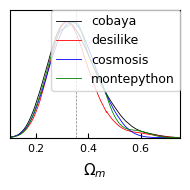

In [34]:
# To load MontePython samples from disk
from datetime import date
from getdist.mcsamples import loadMCSamples
samples_bao_montepython = loadMCSamples('_tests/chains_bao_montepython/{}_3000_'.format(date.today()),
                                    settings={'ignore_rows': 0.5}).copy(label='montepython')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike, samples_bao_cosmosis, samples_bao_montepython],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

## Interlude: forecasts
So far we have input totally ad-hoc covariance matrices.
Yet, one can use desilike to produce forecasts.

In [35]:
from desilike.observables.galaxy_clustering import CutskyFootprint
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, SimpleBAOWigglesTracerPowerSpectrumMultipoles
from desilike.likelihoods.galaxy_clustering import SNWeightedPowerSpectrumLikelihood
from desilike import Fisher

cosmo = DESI()

# Object holding the area and n(z) in (Mpc/h)^(-3)
footprint = CutskyFootprint(area=14000., zrange=np.linspace(0.8, 1.2, 10), nbar=np.full(10, 1e-4), cosmo=cosmo)
z = footprint.zavg

fo = cosmo.get_fourier()
s, s0 = fo.sigma8_z(z, of='delta_cb'), fo.sigma8_z(0., of='delta_cb')
b1 = 0.8 / (s / s0)  # prescription for linear bias
r = 0.5  # reconstruction factor
sigmaper = 9.4 * (s / 0.9)
f = fo.sigma8_z(z, of='theta_cb') / s
params = {'b1': b1, 'sigmapar': r * (1. + f) * sigmaper, 'sigmaper': r * sigmaper}  # fiducial model parameters
covariance_params = {'b1': b1, 'sigmapar': 0., 'sigmaper': 0.}  # fiducial covariance parameters (simple Kaiser model)
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qparqper')
theory = SimpleBAOWigglesTracerPowerSpectrumMultipoles(template=template) # this BAO model shifts wiggles only
for param in theory.init.params.select(basename='al*'):
    param.update(value=0., fixed=True)  # fixing broadband parameters (the wiggles only shift)

# For klim=(0.01, 0.5), we only use the information from the BAO feature in the power spectrum
likelihood = SNWeightedPowerSpectrumLikelihood(theories=theory, data=params, covariance=covariance_params,
                                               footprints=footprint, klim=(0.01, 0.5))
fisher = Fisher(likelihood)  # initializing Fisher
fisher_bao = fisher(**params).view(params=['qpar', 'qper'])  # computing Fisher prediction at fiducial parameters

[000935.42] [0/1] 01-14 08:30  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'dbeta', 'sigmas'].
[000936.60] [0/1] 01-14 08:30  Differentiation           INFO     Using auto-differentiation for parameter qpar.
[000936.83] [0/1] 01-14 08:30  Differentiation           INFO     Using auto-differentiation for parameter qper.
[000937.01] [0/1] 01-14 08:30  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000937.11] [0/1] 01-14 08:30  Differentiation           INFO     Using auto-differentiation for parameter dbeta.
[000937.53] [0/1] 01-14 08:30  Differentiation           INFO     Using auto-differentiation for parameter sigmas.
[000937.54] [0/1] 01-14 08:30  Differentiation           INFO     Differentiation will evaluate 1 points.


In [36]:
print(fisher_bao.to_stats(tablefmt='pretty'))

+-----+---------+
| FoM | 3561.93 |
+-----+---------+
+------+-------+-------+
|      | qpar  | qper  |
+------+-------+-------+
| mean | 1.000 | 1.000 |
| std  | 0.019 | 0.016 |
+------+-------+-------+
+------+---------+---------+
|      |  qpar   |  qper   |
+------+---------+---------+
| qpar | 3.7e-4  | -1.3e-4 |
| qper | -1.3e-4 | 2.6e-4  |
+------+---------+---------+


In [37]:
quantities = ['qpar', 'qper']
# You can directly pass Fisher to BAOCompressionObservable
observable = BAOCompressionObservable(data=fisher_bao, covariance=fisher_bao,
                                      quantities=quantities, z=z)
# Or...
observable = BAOCompressionObservable(data=fisher_bao.mean(quantities),
                                      covariance=fisher_bao.covariance(quantities),
                                      quantities=quantities, z=z)

This observable can be passed to a likelihood, just as previously, to further run cosmological inference.

## ShapeFit likelihood
ShapeFit compressed likelihoods are similar to BAO compressed likelihoods.

In [38]:
from desilike.observables.galaxy_clustering import ShapeFitCompressionObservable

observable = ShapeFitCompressionObservable(data=[1., 1., 1., 0.], covariance=np.diag([0.01, 0.01, 0.01, 0.01]),
                                           quantities=['qpar', 'qper', 'df', 'dm'], z=1.)
# Let's define the likelihood from this observable
likelihood = ObservablesGaussianLikelihood(observable)

This observable can be passed to a likelihood, just as previously, to further run cosmological inference.

# Full likelihoods

Let's write full likelihoods, i.e. with nuisance parameters (bias, stochastic and counterterms not marginalized out).

In [39]:
%%file _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood(cosmo='external'):
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix, TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # Let's define the template = linear power spectrum
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    b1 = 0.5
    footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
                 covariance=None,  # path to mocks, array (covariance matrix), or None
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory)  # previously defined theory
    covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
    cov = covariance(b1=b1)  # evaluate covariance matrix at this parameter
    likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
    observable.init.update(data=observable.flatdata)  # fix the data vector
    template.init.update(cosmo=cosmo)  # let's pass the cosmology
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})
    CosmoSISLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})
    MontePythonLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})

Writing _tests/fs_likelihood.py


Let's generate the static bindings by calling the above Python script

In [40]:
!python _tests/fs_likelihood.py

/local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/numpy/lib/polynomial.py:1338: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
Unbounded prior for parameter sn0; setting to 5-sigma = -5000.000000000001
Unbounded prior for parameter sn0; setting to 5-sigma = 4999.999999970176
Unbounded prior for parameter sn0; setting to 5-sigma = -5000.000000000001
Unbounded prior for parameter sn0; setting to 5-sigma = 4999.999999970176


In [41]:
!ls -la _tests/cobaya_bindings

total 32
drwxr-xr-x  3 adematti idphp 4096 janv. 14 08:30 .
drwxr-xr-x 10 adematti idphp 4096 janv. 14 08:30 ..
-rw-r--r--  1 adematti idphp  514 janv. 14 08:21 bao_likelihood.py
-rw-r--r--  1 adematti idphp  158 janv. 14 08:21 BAOLikelihood.yaml
-rw-r--r--  1 adematti idphp  508 janv. 14 08:30 fs_likelihood.py
-rw-r--r--  1 adematti idphp  533 janv. 14 08:30 FSLikelihood.yaml
-rw-r--r--  1 adematti idphp   59 janv. 14 08:30 __init__.py
drwxr-xr-x  2 adematti idphp 4096 janv. 14 08:18 __pycache__


In [42]:
!ls -la _tests/cosmosis_bindings

total 36
drwxr-xr-x  3 adematti idphp 4096 janv. 14 08:30 .
drwxr-xr-x 10 adematti idphp 4096 janv. 14 08:30 ..
-rw-r--r--  1 adematti idphp    7 janv. 14 08:21 BAOLikelihood_priors.ini
-rw-r--r--  1 adematti idphp  564 janv. 14 08:21 BAOLikelihood.py
-rw-r--r--  1 adematti idphp    7 janv. 14 08:21 BAOLikelihood_values.ini
-rw-r--r--  1 adematti idphp  106 janv. 14 08:30 FSLikelihood_priors.ini
-rw-r--r--  1 adematti idphp  557 janv. 14 08:30 FSLikelihood.py
-rw-r--r--  1 adematti idphp  101 janv. 14 08:30 FSLikelihood_values.ini
drwxr-xr-x  2 adematti idphp 4096 janv. 14 08:21 __pycache__


In [43]:
!ls -la _tests/montepython_bindings

total 16
drwxr-xr-x  4 adematti idphp 4096 janv. 14 08:30 .
drwxr-xr-x 10 adematti idphp 4096 janv. 14 08:30 ..
drwxr-xr-x  2 adematti idphp 4096 janv. 14 08:21 BAOLikelihood
drwxr-xr-x  2 adematti idphp 4096 janv. 14 08:30 FSLikelihood


Yet, the above likelihood will take a significant time to evaluate, especially for a 1-loop EFT model.
Let's emulate the theory.

In [44]:
# %load _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood(cosmo='external'):
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix, TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # Let's define the template = linear power spectrum
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    b1 = 1.5
    footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
                 covariance=None,  # path to mocks, array (covariance matrix), or None
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory)  # previously defined theory
    covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
    cov = covariance(b1=b1)  # evaluate covariance matrix at this parameter
    likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
    observable.init.update(data=observable.flatdata)  # fix the data vector
    template.init.update(cosmo=cosmo)  # let's pass the cosmology
    return likelihood

In [45]:
likelihood = FSLikelihood(cosmo=None)
theory = likelihood.observables[0].wmatrix.theory

from desilike.emulators import Emulator, TaylorEmulatorEngine, EmulatedCalculator

emulator = Emulator(theory.pt,
                    engine=TaylorEmulatorEngine(order={'*': 1}))
emulator.set_samples()
emulator.fit()  # set Taylor expansion

# Emulator can be saved with:
emulator.save('_tests/emulator.npy')
np.save('_tests/data.npy', likelihood.flatdata)
np.save('_tests/covariance.npy', likelihood.covariance)

theory.init.update(pt=emulator)

[001015.39] [0/1] 01-14 08:31  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA'].
[001015.39] [0/1] 01-14 08:31  Emulator                  INFO     Found varying ['pk_dd', 'pk_dt', 'pk_tt', 'pk11'] and fixed ['k', 'z', 'ells', 'names'] outputs.
[001016.63] [0/1] 01-14 08:31  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA'].
[001022.51] [0/1] 01-14 08:31  Differentiation           INFO     Using finite-differentiation for parameter h.
[001023.55] [0/1] 01-14 08:31  Differentiation           INFO     Using finite-differentiation for parameter omega_cdm.
[001024.59] [0/1] 01-14 08:31  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[001025.68] [0/1] 01-14 08:31  Differentiation           INFO     Using finite-differentiation for parameter logA.
[001025.69] [0/1] 01-14 08:31  Differentiation           INFO     h grid is [0.6436 0.6736 0.7036].
[001025.69] [0/1] 01-14 

Now we can write our likelihood, using the emulated PT!

In [46]:
%%file _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood():
    import os
    import numpy as np
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    from desilike.emulators import EmulatedCalculator
    # Let's define the template
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template,
                                                 pt=EmulatedCalculator.load(os.path.join(dirname, 'emulator.npy')))
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data=np.load(os.path.join(dirname, 'data.npy')),  # path to data, *pypower* file, array, or dictionary of parameters
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory,
                 covariance=np.load(os.path.join(dirname, 'covariance.npy')))
    likelihood = ObservablesGaussianLikelihood(observables=observable, name='fs')
    likelihood.all_params['b1'].update(ref=dict(limits=[1., 2.]))
    likelihood.all_params['sn0'].update(derived='.auto')
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})
    CosmoSISLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})
    MontePythonLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})

Overwriting _tests/fs_likelihood.py


Let's generate the static bindings by calling the above Python script

In [47]:
!python _tests/fs_likelihood.py

### Cobaya

In [48]:
%%file _tests/config_bao_fs.yaml

theory:
  classy:
    extra_args:
      N_ncdm: 1
      N_ur: 2.0328

likelihood:
  cobaya_bindings.bao_likelihood.BAOLikelihood:
      python_path: _tests
  cobaya_bindings.fs_likelihood.FSLikelihood:
      python_path: _tests

params:
  Omega_m:
    prior:
      min: 0.1
      max: 1.
    ref:
      dist: norm
      loc: 0.3
      scale: 0.01
    latex: \Omega_{m}
  omega_b: 0.02237
  H0: 67.36
  As: 2.083e-09
  n_s: 0.9649
  tau_reio: 0.0544

sampler:
  mcmc:
    Rminus1_stop: 0.05

debug: False

output: _tests/chains_bao_fs_cobaya/chain

Writing _tests/config_bao_fs.yaml


Let's sample!

In [49]:
!cobaya-run -f _tests/config_bao_fs.yaml

/local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[output] Output to be read-from/written-into folder '_tests/chains_bao_fs_cobaya', with prefix 'chain'
[jax._src.xla_bridge] Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[jax._src.xla_bridge] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
[classy] `classy` module loaded successfully from /local/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/classy-3.2.2-py3.10-linux-x86_64.egg
[BAOCompressionObservable] Found quantities ['qpar', 'qper'].
[BAOCompressionObservable] Found quantities ['qiso'].
[BAOCompressionObservable] Found 

In [50]:
from getdist.mcsamples import loadMCSamples
samples_bao_fs_cobaya = loadMCSamples('_tests/chains_bao_fs_cobaya/chain',
                                      settings={'ignore_rows': 0.5}).copy(label='cobaya')

[001154.62] [0/1] 01-14 08:33  root                      WARNING  outlier fraction 0.12 


### CosmoSIS

In [51]:
%%file _tests/config_bao_fs.ini

[DEFAULT]
fatal_errors = T

[runtime]
sampler = emcee

[output]
filename = _tests/chains_bao_fs_cosmosis/chain.txt
format = text
verbosity = 0

[pipeline]
modules = consistency camb bao fs
values = _tests/values_bao_fs.ini
likelihoods = BAOLikelihood FSLikelihood  ; notice the name of the likelihood: the same as the *.py file
quiet = T
debug = F
timing = F

[bao]
file = _tests/cosmosis_bindings/BAOLikelihood.py

[fs]
file = _tests/cosmosis_bindings/FSLikelihood.py

[consistency]
file = ${COSMOSIS_STD_DIR}/utility/consistency/consistency_interface.py

[camb]
file = ${COSMOSIS_STD_DIR}/boltzmann/camb/camb_interface.py
mode = background
feedback = 0
; We need quite fine redshift spacing, because the supernovae
; go down to low z where things are pretty sensitive
nz = 901

[class]
file = ${COSMOSIS_STD_DIR}/boltzmann/class/class_interface.py
mpk = False
lensing = False
cmb = False

[cosmoprimo]
file = /home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/bindings/cosmosis/cosmoprimo_interface.py
engine = class

[emcee]
walkers = 9
samples = 800
nsteps = 20

[test]
fatal_errors = T

Writing _tests/config_bao_fs.ini


In this case the likelihood has nuisance parameters, to be copied in the input ``*values.ini`` file.

In [52]:
!cat _tests/cosmosis_bindings/FSLikelihood_values.ini

[desi]
sigmapar = 0.0
sigmaper = 0.0
b1 = 0.0 1.5 4.0


In [53]:
%%file _tests/values_bao_fs.ini

[desi]
sigmapar = 0.0
sigmaper = 0.0
b1 = 0.0 1.5 4.0

[cosmological_parameters]
; This is the only parameter being varied.
omega_m = 0.1 0.3 0.9
ombh2 = 0.02237
h0 = 0.6736
A_s = 2.083e-09
n_s = 0.9649
tau = 0.0544

mnu = 0.06
nnu = 3.046
num_massive_neutrinos = 1
omega_k = 0.0
w = -1.0
wa = 0.0

Writing _tests/values_bao_fs.ini


Let's sample!

In [54]:
!cosmosis _tests/config_bao_fs.ini

Deprecated: The [pipeline] quiet option is deprecated.  Set [runtime] verbosity instead.
Setting up pipeline from parameter file _tests/config_bao_fs.ini
----------------------------------------------------------------

Setting up module consistency
------------------------------

Setting up module camb
-----------------------

Setting up module bao
----------------------

Setting up module fs
---------------------
Setup all pipeline modules


Parameter Priors
----------------
desi--sigmapar                                  ~ delta(0.0)
desi--sigmaper                                  ~ delta(0.0)
desi--b1                                        ~ U(0.0, 4.0)
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--ombh2                  ~ delta(0.02237)
cosmological_parameters--h0                     ~ delta(0.6736)
cosmological_parameters--a_s                    ~ delta(2.083e-09)
cosmological_parameters--n_s                    ~ delta(0.9649)
cosmological

In [55]:
# To load CosmoSIS samples
from cosmosis import Inifile
from cosmosis.output import input_from_options
from getdist import MCSamples

ini = Inifile('_tests/config_bao_fs.ini')
options = dict(ini.items('output'))
options['filename'] = '_tests/chains_bao_fs_cosmosis/chain.txt'
column_names, data = input_from_options(options)[:2]
#print(column_names)
data = data[0].T
data = data[..., data.shape[-1] // 2::10]  # removing burnin and thinning
samples_bao_fs_cosmosis = MCSamples(samples=data[:2].T, weights=None, loglikes=-data[-1],
                                    names=['b1', 'Omega_m'], label='cosmosis')

LOADING CHAIN FROM FILE:  _tests/chains_bao_fs_cosmosis/chain.txt


### MontePython

In [56]:
!ls -la _tests/montepython_bindings/FSLikelihood
!cp -r _tests/montepython_bindings/FSLikelihood _tests/montepython_public/montepython/likelihoods/

total 20
drwxr-xr-x 2 adematti idphp 4096 janv. 14 08:30 .
drwxr-xr-x 4 adematti idphp 4096 janv. 14 08:30 ..
-rw-r--r-- 1 adematti idphp   33 janv. 14 08:31 FSLikelihood.data
-rw-r--r-- 1 adematti idphp  268 janv. 14 08:31 FSLikelihood.param
-rw-r--r-- 1 adematti idphp  498 janv. 14 08:31 __init__.py


In this case the likelihood has nuisance parameters, to be copied in the input ``*.param`` file.

In [57]:
!cat _tests/montepython_bindings/FSLikelihood/FSLikelihood.param

# To be copy-pasted in the MontePython *.param file
data.parameters['sigmapar'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['sigmaper'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['b1'] = [1.5, 0.0, 4.0, 0.28867513459481287, 1.0, 'nuisance']


In [75]:
%%file _tests/conf_bao_fs.param

data.experiments = ['BAOLikelihood', 'FSLikelihood']

# Cosmological parameters list
data.parameters['Omega_m'] = [0.3, 0.1, 0.9, 0.1, 1., 'cosmo']
# Fixed parameters
data.parameters['omega_b'] = [0.02237, 0.001, 0.1, 0., 1., 'cosmo']
data.parameters['H0'] = [67.36, 0.1, 0.9, 0., 1., 'cosmo']
data.parameters['A_s'] = [2.083e-09, 1e-09, 3e-09, 0., 1., 'cosmo']
data.parameters['n_s'] = [0.9649, 0.9, 1.0, 0., 1., 'cosmo']
data.parameters['tau_reio'] = [0.0544, 0.02, 0.1, 0., 1., 'cosmo']

# Nuisance parameters list
data.parameters['sigmapar'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['sigmaper'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['b1'] = [1.5, 0.0, 4.0, 0.28867513459481287, 1.0, 'nuisance']

# Cosmo arguments
data.cosmo_arguments['k_pivot'] = 0.05
# The base model features two massless
# and one massive neutrino with m=0.06eV.
# The settings below ensures that Neff=3.046
# and m/omega = 93.14 eV
data.cosmo_arguments['N_ur'] = 2.0328
data.cosmo_arguments['N_ncdm'] = 1
data.cosmo_arguments['m_ncdm'] = 0.06
data.cosmo_arguments['T_ncdm'] = 0.71611

#------ MCMC parameters ----
# Number of steps taken, by default (overwritten by the -N command)
data.N = 10000
# Number of accepted steps before writing to file the chain. Larger means less
# access to disc, but this is not so much time consuming.
data.write_step = 10

Overwriting _tests/conf_bao_fs.param


Let's sample!

In [ ]:
!python _tests/montepython_public/montepython/MontePython.py run --conf _tests/montepython_public/default.conf -p _tests/conf_bao_fs.param -m MH -o _tests/chains_bao_fs_montepython

 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.1

with CLASS v3.2.2

Testing likelihoods for:
 ->BAOLikelihood, FSLikelihood

Creating _tests/chains_bao_fs_montepython/2025-01-14_10000__1.txt


Deduced starting covariance matrix:

['Omega_m', 'b1']
[[0.01 0.  ]
 [0.   0.08]]
Update routine is enabled with value 50 (recommended: 50)
This number is rescaled by cycle length 2 (N_slow + f_fast * N_fast) to 100

#  -LogLkl	Omega_m         b1              
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
 /!\ PyMultiNest d

2  7.82642	3.261295e-01	1.466512e+00	
2  7.99272	3.267182e-01	1.465676e+00	
2  7.69421	3.256206e-01	1.467234e+00	
2  7.81048	3.260703e-01	1.466596e+00	
1  8.48029	3.282165e-01	1.463549e+00	
1  8.73644	3.282165e-01	1.472115e+00	
2  7.9119	3.262156e-01	1.474956e+00	
4  7.62951	3.254182e-01	1.476088e+00	
2  7.61393	3.253719e-01	1.476153e+00	
2  8.46771	3.276068e-01	1.472981e+00	
2  8.97357	3.287280e-01	1.471389e+00	
2  8.05276	3.265878e-01	1.474427e+00	
2  7.68232	3.255732e-01	1.475868e+00	
4  7.37763	3.246338e-01	1.477201e+00	
1  6.55336	3.210163e-01	1.482336e+00	
1  7.23622	3.210163e-01	1.471304e+00	
2  7.26316	3.216708e-01	1.470375e+00	
2  7.23597	3.197709e-01	1.473072e+00	
1  7.23267	3.199100e-01	1.472875e+00	
2  7.68501	3.199100e-01	1.504321e+00	
1  6.41923	3.199100e-01	1.483703e+00	
2  6.42391	3.199563e-01	1.483637e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 643 steps
--> Computing mean valu

1  7.44254	3.067011e-01	1.532032e+00	
2  7.68405	3.054582e-01	1.533796e+00	
2  7.69382	3.054149e-01	1.533858e+00	
1  7.90729	3.045555e-01	1.535078e+00	
1  7.79662	3.045555e-01	1.531177e+00	
2  7.21255	3.067909e-01	1.528004e+00	
1  7.90738	3.042147e-01	1.531661e+00	
1  8.08707	3.042147e-01	1.537322e+00	
2  8.13468	3.040383e-01	1.537573e+00	
2  8.35929	3.032728e-01	1.538659e+00	
1  8.96394	3.015726e-01	1.541073e+00	
1  9.13158	3.015726e-01	1.545161e+00	
4  8.80383	3.025860e-01	1.543722e+00	
2  8.47326	3.038275e-01	1.541960e+00	
2  9.08982	3.016933e-01	1.544990e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 735 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001939 	for  Omega_m
           0.000667 	for  b1
--> Not computing covariance matrix
8  9.48483	3.006267e-01	1.546504e+00	
3  9.62341	3.002858e-01	1.546988e+00	
3  9.66902	3.

1  8.24924	3.197565e-01	1.508228e+00	
1  8.1787	3.195685e-01	1.508495e+00	
1  6.65972	3.195685e-01	1.496690e+00	
1  6.46863	3.186563e-01	1.497985e+00	
1  6.51155	3.186563e-01	1.482250e+00	
2  6.52085	3.191395e-01	1.481564e+00	
2  6.68917	3.156238e-01	1.486555e+00	
2  6.53128	3.174945e-01	1.483899e+00	
2  6.54041	3.196233e-01	1.480877e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 828 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001617 	for  Omega_m
           0.000971 	for  b1
--> Not computing covariance matrix
2  6.51413	3.180656e-01	1.483089e+00	
1  6.56499	3.168932e-01	1.484753e+00	
1  6.22922	3.168932e-01	1.489563e+00	
1  6.27359	3.186913e-01	1.487011e+00	
1  6.3897	3.186913e-01	1.496504e+00	
2  6.1643	3.170542e-01	1.498828e+00	
2  6.05643	3.153131e-01	1.501300e+00	
2  6.19282	3.173204e-01	1.498450e+00	
1  6.69378	3.201

2  6.83921	3.136549e-01	1.517519e+00	
2  7.14514	3.156118e-01	1.514741e+00	
1  6.74616	3.125752e-01	1.519052e+00	
1  6.20535	3.125752e-01	1.510929e+00	
2  6.46871	3.099030e-01	1.514723e+00	
1  6.87237	3.079613e-01	1.517479e+00	
1  6.86675	3.079613e-01	1.522580e+00	
1  6.47518	3.116626e-01	1.517326e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 923 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000737 	for  Omega_m
           0.000777 	for  b1
--> Not computing covariance matrix
1  6.24114	3.116626e-01	1.508380e+00	
1  6.40416	3.105699e-01	1.509931e+00	
2  6.38421	3.105699e-01	1.510892e+00	
1  6.56683	3.105699e-01	1.519674e+00	
2  6.58041	3.103611e-01	1.519970e+00	
2  6.65407	3.095384e-01	1.521138e+00	
2  6.56846	3.105431e-01	1.519712e+00	
2  6.71433	3.090405e-01	1.521845e+00	
2  6.83521	3.082456e-01	1.522973e+00	
1  6.64108	3.

1  7.66207	3.203987e-01	1.468843e+00	
2  7.65823	3.205133e-01	1.468680e+00	
2  7.69929	3.227974e-01	1.465438e+00	
1  7.95131	3.250178e-01	1.462286e+00	
1  7.65535	3.250178e-01	1.480057e+00	
2  7.75639	3.252941e-01	1.479665e+00	
2  8.7519	3.276603e-01	1.476306e+00	
1  8.56842	3.272627e-01	1.476870e+00	
3  8.83853	3.272627e-01	1.479583e+00	
1  8.62338	3.268103e-01	1.480226e+00	
1  9.36232	3.268103e-01	1.485836e+00	
2  9.71695	3.274601e-01	1.484914e+00	
1  9.7504	3.275197e-01	1.484829e+00	
1  9.41885	3.275197e-01	1.482702e+00	
2  9.50336	3.276763e-01	1.482479e+00	
2  8.79569	3.263008e-01	1.484432e+00	
2  8.22419	3.250583e-01	1.486196e+00	
2  8.2474	3.251116e-01	1.486120e+00	
2  6.18521	3.176341e-01	1.496734e+00	
2  6.26501	3.182659e-01	1.495838e+00	
1  6.34057	3.187649e-01	1.495129e+00	
1  6.49453	3.187649e-01	1.497906e+00	
1  6.73925	3.198793e-01	1.496324e+00	
3  6.36804	3.198793e-01	1.487412e+00	
2  6.33918	3.196668e-01	1.487713e+00	
1  6.54986	3.209844e-01	1.485843e+00	
2  6.57294	3.20

1  9.93698	3.096359e-01	1.486868e+00	
1  11.4322	3.069401e-01	1.490695e+00	
3  7.59098	3.069401e-01	1.512077e+00	
1  7.91834	3.061270e-01	1.513231e+00	
1  7.57161	3.061270e-01	1.517359e+00	
1  7.13517	3.073950e-01	1.515559e+00	
1  7.5857	3.073950e-01	1.533744e+00	
1  7.50253	3.086425e-01	1.531973e+00	
3  6.70739	3.086425e-01	1.516715e+00	
4  6.51626	3.096176e-01	1.515331e+00	
4  6.63524	3.089842e-01	1.516230e+00	
1  6.276	3.114879e-01	1.512676e+00	
1  6.45587	3.114879e-01	1.503360e+00	
1  6.058	3.153041e-01	1.497942e+00	
1  6.76631	3.153041e-01	1.486693e+00	
1  6.81128	3.150062e-01	1.487116e+00	
1  6.0731	3.150062e-01	1.497965e+00	
2  6.05968	3.157207e-01	1.496951e+00	
2  6.14675	3.177472e-01	1.494074e+00	
1  6.07574	3.149342e-01	1.498068e+00	
1  6.06655	3.149342e-01	1.502915e+00	
1  6.10255	3.158589e-01	1.501602e+00	
1  6.09079	3.158589e-01	1.495125e+00	
1  6.09409	3.156854e-01	1.495371e+00	
1  6.05264	3.156854e-01	1.499637e+00	
3  6.06371	3.160137e-01	1.499171e+00	
1  6.06572	3.16013

2  6.13138	3.166326e-01	1.499616e+00	
2  6.35544	3.184299e-01	1.497064e+00	
1  6.50604	3.192532e-01	1.495896e+00	
1  6.28859	3.192532e-01	1.488321e+00	
2  6.25378	3.189249e-01	1.488788e+00	
2  6.15136	3.161074e-01	1.492787e+00	
2  6.14589	3.170269e-01	1.491482e+00	
2  6.14356	3.167549e-01	1.491868e+00	
2  6.14426	3.165146e-01	1.492209e+00	
1  6.24481	3.145783e-01	1.494958e+00	
1  6.29546	3.145783e-01	1.494129e+00	
1  6.17842	3.173961e-01	1.490129e+00	
1  6.16587	3.173961e-01	1.497289e+00	
2  6.28117	3.183203e-01	1.495977e+00	
2  6.18589	3.175810e-01	1.497026e+00	
4  6.04544	3.149814e-01	1.500716e+00	
1  6.07859	3.162994e-01	1.498845e+00	
1  6.06294	3.162994e-01	1.497023e+00	
2  6.6174	3.205878e-01	1.490935e+00	
1  7.11253	3.224611e-01	1.488276e+00	
1  9.7385	3.224611e-01	1.505745e+00	
1  11.591	3.256413e-01	1.501231e+00	
1  7.63757	3.256413e-01	1.469525e+00	
2  6.83425	3.212822e-01	1.475713e+00	
2  6.82649	3.211956e-01	1.475836e+00	
4  6.88486	3.217776e-01	1.475010e+00	
4  6.76193	3.20

1  6.94169	3.150852e-01	1.514682e+00	
2  6.91379	3.149144e-01	1.514924e+00	
2  7.01499	3.154997e-01	1.514094e+00	
4  6.6765	3.127498e-01	1.517997e+00	
2  6.64894	3.121399e-01	1.518863e+00	
2  7.07349	3.158025e-01	1.513664e+00	
2  6.72743	3.134271e-01	1.517036e+00	
1  7.28069	3.167386e-01	1.512335e+00	
1  6.42808	3.167386e-01	1.504686e+00	
1  6.57177	3.175852e-01	1.503484e+00	
1  6.15642	3.175852e-01	1.490895e+00	
2  6.13821	3.163916e-01	1.492589e+00	
1  6.13837	3.163786e-01	1.492607e+00	
1  6.18524	3.163786e-01	1.501981e+00	
1  7.05497	3.208250e-01	1.495669e+00	
1  6.54081	3.208250e-01	1.481831e+00	
2  6.8862	3.227917e-01	1.479039e+00	
2  6.7302	3.220163e-01	1.480140e+00	
2  6.37597	3.191054e-01	1.484272e+00	
1  6.35961	3.187865e-01	1.484725e+00	
1  7.23943	3.187865e-01	1.505256e+00	
2  7.44318	3.194681e-01	1.504288e+00	
2  7.12447	3.183678e-01	1.505850e+00	
2  7.12751	3.183792e-01	1.505834e+00	
2  6.72307	3.165866e-01	1.508378e+00	
2  6.4966	3.150909e-01	1.510502e+00	
1  6.74493	3.167

1  6.45034	3.201091e-01	1.489874e+00	
1  7.7119	3.201091e-01	1.503766e+00	
2  7.62542	3.198558e-01	1.504125e+00	
1  7.15678	3.183009e-01	1.506332e+00	
1  8.39764	3.183009e-01	1.513889e+00	
1  7.75148	3.162331e-01	1.516825e+00	
1  6.29962	3.162331e-01	1.489663e+00	
2  6.26983	3.170694e-01	1.488476e+00	
2  6.26674	3.175241e-01	1.487830e+00	
1  6.47851	3.143748e-01	1.492301e+00	
1  6.23406	3.143748e-01	1.495788e+00	
2  6.75291	3.113105e-01	1.500138e+00	
2  6.59163	3.120322e-01	1.499113e+00	
2  6.14737	3.155916e-01	1.494061e+00	
1  6.14456	3.174671e-01	1.491398e+00	
1  6.5057	3.174671e-01	1.503128e+00	
1  6.20714	3.150217e-01	1.506600e+00	
1  6.10501	3.150217e-01	1.496735e+00	
1  6.09013	3.167766e-01	1.494244e+00	
1  6.2848	3.167766e-01	1.502467e+00	
2  6.55437	3.184237e-01	1.500129e+00	
4  6.77912	3.194327e-01	1.498697e+00	
2  6.97046	3.201654e-01	1.497657e+00	
1  6.76453	3.193728e-01	1.498782e+00	
1  6.363	3.193728e-01	1.484728e+00	
2  6.52308	3.208155e-01	1.482680e+00	
2  6.35612	3.1586

6  7.1182	3.069938e-01	1.519597e+00	
3  7.10353	3.070442e-01	1.519525e+00	
1  8.14207	3.070442e-01	1.506675e+00	
1  7.72089	3.080645e-01	1.505227e+00	
3  7.16911	3.080645e-01	1.528937e+00	
1  7.05269	3.096623e-01	1.526669e+00	
1  6.86037	3.096623e-01	1.524465e+00	
2  6.89521	3.091827e-01	1.525146e+00	
1  7.12395	3.073873e-01	1.527695e+00	
1  7.20023	3.073873e-01	1.529053e+00	
2  7.01027	3.090505e-01	1.526692e+00	
2  7.05964	3.084871e-01	1.527492e+00	
8  8.54455	3.024984e-01	1.535993e+00	
1  8.09194	3.037358e-01	1.534236e+00	
1  8.57301	3.037358e-01	1.521138e+00	
2  10.1033	3.009887e-01	1.525038e+00	
1  10.1182	3.009648e-01	1.525072e+00	
1  10.242	3.009648e-01	1.524096e+00	
1  10.4479	3.006464e-01	1.524548e+00	
1  9.38706	3.006464e-01	1.544021e+00	
1  9.91517	2.994890e-01	1.545664e+00	
1  9.9061	2.994890e-01	1.544016e+00	
2  8.95837	3.015857e-01	1.541039e+00	
4  8.89869	3.017370e-01	1.540825e+00	
2  9.09077	3.012601e-01	1.541502e+00	
2  7.78745	3.054927e-01	1.535493e+00	
4  7.87582	3.05

1  6.41354	3.161594e-01	1.488227e+00	
2  6.52871	3.150162e-01	1.489850e+00	
1  6.66804	3.140742e-01	1.491187e+00	
1  6.56026	3.140742e-01	1.492304e+00	
2  6.59738	3.138452e-01	1.492629e+00	
2  6.3192	3.163806e-01	1.489030e+00	
2  6.45202	3.202812e-01	1.483493e+00	
2  6.51926	3.207948e-01	1.482764e+00	
2  7.33299	3.244760e-01	1.477539e+00	
2  6.75926	3.221889e-01	1.480785e+00	
1  6.35489	3.192919e-01	1.484897e+00	
1  6.95923	3.192919e-01	1.476259e+00	
2  6.9903	3.184738e-01	1.477421e+00	
2  6.95658	3.194511e-01	1.476033e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 1590 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000155 	for  Omega_m
           0.000025 	for  b1
--> Not computing covariance matrix
3  6.97775	3.187225e-01	1.477068e+00	
1  6.24637	3.187225e-01	1.492297e+00	
1  6.74878	3.214213e-01	1.488466e+00	
3  8.39488	3.2

2  10.9265	3.030811e-01	1.558732e+00	
2  10.8979	3.056271e-01	1.555118e+00	
1  10.8924	3.036357e-01	1.557945e+00	
1  8.28572	3.036357e-01	1.538851e+00	
2  7.78552	3.057913e-01	1.535792e+00	
1  7.65805	3.065943e-01	1.534652e+00	
1  7.52854	3.065943e-01	1.514860e+00	
2  7.37951	3.070043e-01	1.514277e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 1683 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000045 	for  Omega_m
           0.000120 	for  b1
--> Not computing covariance matrix
2  7.50443	3.066592e-01	1.514767e+00	
2  6.90953	3.084829e-01	1.512179e+00	
2  6.64819	3.094953e-01	1.510741e+00	
3  6.61861	3.096234e-01	1.510560e+00	
1  6.79897	3.096234e-01	1.507311e+00	
2  6.52436	3.107770e-01	1.505673e+00	
2  6.56588	3.105842e-01	1.505947e+00	
2  6.35299	3.116804e-01	1.504391e+00	
2  6.36161	3.116296e-01	1.504463e+00	
1  6.04645	3

1  6.6642	3.112954e-01	1.520367e+00	
2  7.1376	3.069452e-01	1.526542e+00	
1  7.07579	3.072446e-01	1.526117e+00	
1  7.07606	3.072446e-01	1.518219e+00	
1  7.15588	3.069775e-01	1.518599e+00	
1  8.85226	3.069775e-01	1.502324e+00	
4  8.92453	3.068310e-01	1.502532e+00	
1  7.34495	3.107429e-01	1.496979e+00	
1  9.07777	3.107429e-01	1.486867e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 1778 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000070 	for  Omega_m
           0.000058 	for  b1
--> Not computing covariance matrix
4  8.02152	3.137326e-01	1.482623e+00	
2  7.55656	3.156617e-01	1.479885e+00	
1  9.47862	3.098390e-01	1.488150e+00	
1  8.73613	3.098390e-01	1.537791e+00	
2  8.62733	3.064271e-01	1.542634e+00	
1  8.62045	3.083845e-01	1.539855e+00	
1  6.75979	3.083845e-01	1.517486e+00	
1  7.25886	3.065454e-01	1.520096e+00	
1  7.19335	3.0

2  6.11586	3.158171e-01	1.502163e+00	
1  6.35158	3.179313e-01	1.499162e+00	
3  7.35004	3.179313e-01	1.508988e+00	
2  7.82287	3.194560e-01	1.506824e+00	
1  7.82603	3.194652e-01	1.506811e+00	
1  6.39332	3.194652e-01	1.483932e+00	
1  6.33714	3.183953e-01	1.485450e+00	
1  6.76946	3.183953e-01	1.502639e+00	
1  6.19324	3.137164e-01	1.509281e+00	
1  6.10236	3.137164e-01	1.506504e+00	
4  6.25307	3.166615e-01	1.502323e+00	
2  6.40071	3.177055e-01	1.500841e+00	
2  6.12947	3.152106e-01	1.504383e+00	
2  6.15449	3.125231e-01	1.508197e+00	
2  6.23107	3.116811e-01	1.509393e+00	
2  6.14992	3.125887e-01	1.508104e+00	
2  6.11027	3.147514e-01	1.505034e+00	
2  6.10561	3.135529e-01	1.506736e+00	
1  6.10589	3.135414e-01	1.506752e+00	
1  7.78034	3.135414e-01	1.524355e+00	
1  8.06949	3.148656e-01	1.522475e+00	
1  7.27102	3.148656e-01	1.483944e+00	
2  7.5365	3.136999e-01	1.485599e+00	
6  7.2368	3.150390e-01	1.483698e+00	
1  7.01678	3.163876e-01	1.481784e+00	
1  7.65267	3.163876e-01	1.515783e+00	
4  7.82787	3.1

1  6.32059	3.117442e-01	1.514328e+00	
2  6.4238	3.104409e-01	1.516178e+00	
2  6.32337	3.116884e-01	1.514407e+00	
2  6.30979	3.135717e-01	1.511733e+00	
1  6.36361	3.145007e-01	1.510415e+00	
1  6.48709	3.145007e-01	1.511954e+00	
1  6.78681	3.082568e-01	1.520817e+00	
3  7.36204	3.082568e-01	1.507552e+00	
1  7.44385	3.080265e-01	1.507879e+00	
1  7.16097	3.080265e-01	1.511086e+00	
2  7.99648	3.058139e-01	1.514227e+00	
2  7.21797	3.078529e-01	1.511332e+00	
2  6.79768	3.092592e-01	1.509336e+00	
2  7.0131	3.084991e-01	1.510415e+00	
2  7.31867	3.075565e-01	1.511753e+00	
2  7.04886	3.083816e-01	1.510582e+00	
3  6.20221	3.123573e-01	1.504938e+00	
1  6.16612	3.123573e-01	1.508219e+00	
2  6.22012	3.117878e-01	1.509027e+00	
1  6.72492	3.089151e-01	1.513105e+00	
1  6.94119	3.089151e-01	1.525836e+00	
2  7.30348	3.065190e-01	1.529237e+00	
1  7.25951	3.067343e-01	1.528932e+00	
1  7.88569	3.067343e-01	1.510280e+00	
2  7.38091	3.080456e-01	1.508418e+00	
2  6.78654	3.099798e-01	1.505673e+00	
2  6.68079	3.1

1  6.16342	3.178910e-01	1.494149e+00	
2  6.10479	3.171758e-01	1.495164e+00	
2  6.06734	3.150058e-01	1.498245e+00	
2  6.06332	3.151466e-01	1.498045e+00	
2  6.0727	3.148538e-01	1.498461e+00	
1  6.33503	3.122110e-01	1.502212e+00	
1  6.438	3.122110e-01	1.516050e+00	
2  6.59581	3.147812e-01	1.512402e+00	
2  6.4928	3.137087e-01	1.513924e+00	
1  6.51309	3.139709e-01	1.513552e+00	
1  6.20565	3.139709e-01	1.509059e+00	
2  6.22043	3.143528e-01	1.508516e+00	
2  6.23163	3.120822e-01	1.511740e+00	
2  6.20173	3.128224e-01	1.510689e+00	
2  6.22231	3.122562e-01	1.511493e+00	
1  6.3504	3.159153e-01	1.506299e+00	
1  6.18466	3.159153e-01	1.503532e+00	
2  6.67597	3.190540e-01	1.499076e+00	
1  6.76462	3.194316e-01	1.498540e+00	
1  6.3093	3.194316e-01	1.488462e+00	
2  6.50168	3.206883e-01	1.486678e+00	
2  7.24711	3.237208e-01	1.482374e+00	
2  7.38347	3.241474e-01	1.481768e+00	
2  7.55678	3.246579e-01	1.481044e+00	
3  8.18256	3.262859e-01	1.478733e+00	
1  7.92294	3.262859e-01	1.474514e+00	
1  7.4378	3.248592

1  6.95483	3.132165e-01	1.519524e+00	
1  7.80769	3.132165e-01	1.525320e+00	
2  7.88809	3.136426e-01	1.524715e+00	
2  7.63439	3.120772e-01	1.526937e+00	
2  8.10391	3.146182e-01	1.523330e+00	
2  8.24586	3.151715e-01	1.522545e+00	
3  7.87985	3.136009e-01	1.524774e+00	
1  6.23991	3.136009e-01	1.498343e+00	
2  6.17946	3.182118e-01	1.491798e+00	
2  6.12293	3.174386e-01	1.492895e+00	
2  6.15208	3.178817e-01	1.492266e+00	
2  6.23717	3.187738e-01	1.491000e+00	
2  6.09317	3.157111e-01	1.495347e+00	
2  6.14734	3.145699e-01	1.496967e+00	
2  6.14738	3.178184e-01	1.492356e+00	
2  6.0953	3.167609e-01	1.493857e+00	
2  6.09098	3.165549e-01	1.494150e+00	
2  6.13827	3.176881e-01	1.492541e+00	
2  6.08817	3.162801e-01	1.494540e+00	
2  6.1828	3.182485e-01	1.491745e+00	
2  6.34206	3.195651e-01	1.489876e+00	
1  6.14678	3.178102e-01	1.492368e+00	
1  6.15089	3.178102e-01	1.491718e+00	
2  6.10551	3.160614e-01	1.494200e+00	
2  6.14062	3.176425e-01	1.491956e+00	
1  6.38673	3.199224e-01	1.488720e+00	
1  6.70314	3.1

3  6.89434	3.141838e-01	1.488796e+00	
1  6.82846	3.145478e-01	1.488279e+00	
1  6.07073	3.145478e-01	1.499634e+00	
2  6.05308	3.159265e-01	1.497677e+00	
2  6.15985	3.177342e-01	1.495111e+00	
3  6.1552	3.176869e-01	1.495178e+00	
1  6.22078	3.176869e-01	1.488700e+00	
2  6.23071	3.163256e-01	1.490633e+00	
2  6.25117	3.158943e-01	1.491245e+00	
2  6.27714	3.155007e-01	1.491804e+00	
4  6.36121	3.146151e-01	1.493061e+00	
1  6.32399	3.149626e-01	1.492568e+00	
1  7.03677	3.149626e-01	1.515759e+00	
2  7.12079	3.154212e-01	1.515108e+00	
1  7.2759	3.161582e-01	1.514062e+00	
3  8.46501	3.161582e-01	1.520813e+00	
2  7.68844	3.128396e-01	1.525524e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 2253 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000567 	for  Omega_m
           0.000320 	for  b1
--> Not computing covariance matrix
2  7.49344	3.1

1  7.09246	3.082714e-01	1.527933e+00	
1  6.9914	3.095459e-01	1.526123e+00	
1  6.61071	3.095459e-01	1.511311e+00	
2  6.9765	3.081282e-01	1.513324e+00	
1  7.02644	3.079595e-01	1.513563e+00	
1  8.00647	3.079595e-01	1.503517e+00	
3  7.58382	3.090482e-01	1.501972e+00	
1  7.02975	3.090482e-01	1.507242e+00	
1  6.6044	3.106554e-01	1.504961e+00	
2  7.14593	3.106554e-01	1.526180e+00	
1  6.38879	3.106554e-01	1.515388e+00	
2  6.29536	3.118702e-01	1.513663e+00	
2  6.42529	3.103328e-01	1.515846e+00	
2  7.68634	3.051760e-01	1.523166e+00	
1  7.46843	3.057901e-01	1.522294e+00	
5  8.05606	3.057901e-01	1.513779e+00	
1  8.21983	3.054237e-01	1.514299e+00	
1  8.3572	3.054237e-01	1.513089e+00	
1  7.62536	3.071337e-01	1.510662e+00	
1  8.33056	3.071337e-01	1.504922e+00	
1  8.30404	3.071926e-01	1.504838e+00	
1  7.8203	3.071926e-01	1.536003e+00	
1  7.75186	3.091648e-01	1.533204e+00	
1  7.6067	3.091648e-01	1.532142e+00	
2  7.63063	3.081702e-01	1.533554e+00	
2  7.60932	3.094956e-01	1.531672e+00	
2  7.63578	3.10266

2  8.46327	3.131040e-01	1.529086e+00	
1  8.27645	3.121511e-01	1.530439e+00	
1  6.61233	3.121511e-01	1.518426e+00	
1  6.62199	3.107376e-01	1.520433e+00	
2  6.34542	3.107376e-01	1.511968e+00	
1  6.46084	3.107376e-01	1.517597e+00	
2  6.40386	3.125475e-01	1.515028e+00	
2  6.54083	3.147543e-01	1.511895e+00	
2  7.08515	3.177578e-01	1.507632e+00	
1  6.52144	3.145762e-01	1.512148e+00	
1  6.15478	3.145762e-01	1.496768e+00	
2  6.13435	3.148744e-01	1.496344e+00	
2  6.15977	3.145111e-01	1.496860e+00	
2  6.1057	3.170112e-01	1.493311e+00	
1  6.1765	3.181785e-01	1.491654e+00	
1  6.7134	3.181785e-01	1.502869e+00	
2  6.1888	3.136453e-01	1.509304e+00	
2  6.29073	3.112667e-01	1.512681e+00	
1  6.39099	3.104195e-01	1.513884e+00	
1  6.64281	3.104195e-01	1.505543e+00	
3  6.05566	3.149636e-01	1.499092e+00	
1  6.05648	3.149636e-01	1.499031e+00	
2  6.45789	3.112980e-01	1.504234e+00	
2  6.24513	3.125933e-01	1.502396e+00	
1  6.44206	3.113802e-01	1.504118e+00	
1  8.56425	3.113802e-01	1.487226e+00	
1  7.70397	3.140

1  6.87854	3.079223e-01	1.517704e+00	
1  6.88235	3.079223e-01	1.523004e+00	
4  7.32609	3.060523e-01	1.525658e+00	
2  6.77263	3.085424e-01	1.522124e+00	
2  6.89782	3.078424e-01	1.523117e+00	
2  6.74493	3.087181e-01	1.521874e+00	
2  6.67319	3.092255e-01	1.521154e+00	
2  6.58973	3.099754e-01	1.520089e+00	
4  7.08383	3.069836e-01	1.524336e+00	
1  7.37753	3.058733e-01	1.525912e+00	
1  7.40256	3.058733e-01	1.523600e+00	
2  7.48477	3.056205e-01	1.523959e+00	
1  7.33266	3.060963e-01	1.523284e+00	
1  12.2999	3.060963e-01	1.559475e+00	
1  12.144	3.045962e-01	1.561604e+00	
1  7.92015	3.045962e-01	1.523761e+00	
1  7.5164	3.056739e-01	1.522231e+00	
1  7.70215	3.056739e-01	1.534532e+00	
2  7.52729	3.066597e-01	1.533133e+00	
2  7.69416	3.057137e-01	1.534475e+00	
2  8.26552	3.034755e-01	1.537653e+00	
2  8.11897	3.039659e-01	1.536957e+00	
1  7.62022	3.061027e-01	1.533923e+00	
2  8.88312	3.061027e-01	1.505999e+00	
1  8.03961	3.061027e-01	1.512215e+00	
1  6.82355	3.095559e-01	1.507314e+00	
1  6.90246	3.0

1  6.22687	3.146190e-01	1.495151e+00	
2  6.40952	3.131527e-01	1.497233e+00	
2  6.38324	3.133231e-01	1.496991e+00	
1  6.73859	3.114809e-01	1.499606e+00	
2  6.47795	3.114809e-01	1.503026e+00	
1  8.81162	3.114809e-01	1.485659e+00	
2  8.72567	3.117043e-01	1.485342e+00	
3  7.62514	3.154512e-01	1.480023e+00	
1  6.09514	3.154512e-01	1.495890e+00	
1  6.11665	3.149484e-01	1.496603e+00	
1  6.28037	3.149484e-01	1.493269e+00	
2  6.46646	3.134696e-01	1.495368e+00	
2  6.25764	3.152120e-01	1.492894e+00	
1  6.25617	3.152304e-01	1.492868e+00	
1  6.08924	3.152304e-01	1.496673e+00	
1  6.10511	3.148709e-01	1.497184e+00	
1  6.06219	3.148709e-01	1.498961e+00	
4  6.28768	3.123533e-01	1.502535e+00	
2  6.42304	3.115403e-01	1.503689e+00	
2  6.72802	3.101425e-01	1.505673e+00	
2  6.22371	3.128210e-01	1.501871e+00	
2  6.18825	3.131188e-01	1.501448e+00	
1  6.18129	3.131817e-01	1.501359e+00	
1  6.11054	3.131817e-01	1.506674e+00	
2  6.09334	3.147884e-01	1.504393e+00	
1  6.29264	3.112261e-01	1.509450e+00	
1  6.75015	3

1  8.32877	3.115491e-01	1.532085e+00	
2  8.98418	3.144766e-01	1.527929e+00	
1  8.94643	3.143461e-01	1.528114e+00	
1  7.11513	3.143461e-01	1.517988e+00	
1  7.05135	3.139239e-01	1.518587e+00	
1  7.76918	3.139239e-01	1.483495e+00	
1  7.93837	3.133141e-01	1.484361e+00	
1  6.40476	3.133141e-01	1.496719e+00	
2  6.2698	3.143503e-01	1.495248e+00	
2  6.27566	3.142960e-01	1.495326e+00	
2  6.20182	3.151125e-01	1.494167e+00	
2  6.1447	3.166370e-01	1.492003e+00	
1  6.15084	3.161799e-01	1.492651e+00	
1  8.38412	3.161799e-01	1.520354e+00	
2  8.20763	3.155758e-01	1.521211e+00	
2  7.57355	3.125283e-01	1.525537e+00	
1  7.37554	3.094010e-01	1.529976e+00	
1  6.57075	3.094010e-01	1.518118e+00	
1  6.40399	3.107776e-01	1.516164e+00	
1  6.39897	3.107776e-01	1.516010e+00	
2  6.38497	3.109394e-01	1.515781e+00	
2  6.42462	3.105120e-01	1.516387e+00	
1  6.49351	3.099226e-01	1.517224e+00	
1  6.4794	3.099226e-01	1.516465e+00	
1  6.89673	3.077467e-01	1.519554e+00	
1  7.42258	3.077467e-01	1.531940e+00	
1  7.56674	3.06

2  6.34066	3.114645e-01	1.514847e+00	
2  6.52016	3.158279e-01	1.508654e+00	
1  6.31358	3.134604e-01	1.512014e+00	
1  6.14955	3.134604e-01	1.508534e+00	
1  6.15173	3.139985e-01	1.507770e+00	
3  6.06611	3.139985e-01	1.503170e+00	
3  6.06422	3.140509e-01	1.503096e+00	
1  6.53559	3.140509e-01	1.492650e+00	
1  6.59598	3.136800e-01	1.493176e+00	
1  6.49259	3.136800e-01	1.513987e+00	
2  6.86399	3.164533e-01	1.510050e+00	
1  7.32275	3.183639e-01	1.507338e+00	
2  6.23628	3.183639e-01	1.488096e+00	
1  6.61135	3.183639e-01	1.501056e+00	
2  6.63215	3.184629e-01	1.500915e+00	
1  6.14929	3.146456e-01	1.506334e+00	
1  6.29502	3.146456e-01	1.509062e+00	
2  6.45653	3.161579e-01	1.506916e+00	
1  6.50085	3.164574e-01	1.506490e+00	
1  7.1891	3.164574e-01	1.480310e+00	
1  7.03905	3.177488e-01	1.478477e+00	
1  7.65259	3.177488e-01	1.474151e+00	
2  7.50644	3.225375e-01	1.467353e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, 

1  6.07712	3.147528e-01	1.503835e+00	
2  6.33088	3.110364e-01	1.509111e+00	
1  6.28996	3.113123e-01	1.508719e+00	
1  7.01442	3.113123e-01	1.497540e+00	
2  7.11202	3.109608e-01	1.498039e+00	
1  7.2151	3.106102e-01	1.498536e+00	
1  6.45721	3.106102e-01	1.517456e+00	
2  6.73164	3.085468e-01	1.520385e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 2915 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000452 	for  Omega_m
           0.000668 	for  b1
--> Not computing covariance matrix
2  6.71078	3.086630e-01	1.520220e+00	
2  6.81777	3.081007e-01	1.521018e+00	
2  6.39149	3.117738e-01	1.515804e+00	
2  6.40663	3.134153e-01	1.513474e+00	
1  6.72522	3.162476e-01	1.509453e+00	
1  6.06152	3.162476e-01	1.497331e+00	
2  6.1726	3.131577e-01	1.501718e+00	
2  6.18346	3.130580e-01	1.501859e+00	
1  6.09211	3.141065e-01	1.500371e+00	
1  6.55274	3.1

1  6.25984	3.126564e-01	1.512290e+00	
1  6.37008	3.126564e-01	1.514332e+00	
2  6.44859	3.143024e-01	1.511996e+00	
2  6.36934	3.125530e-01	1.514479e+00	
2  6.42898	3.108530e-01	1.516892e+00	
2  6.5013	3.100784e-01	1.517992e+00	
2  6.37803	3.118338e-01	1.515500e+00	
2  6.48244	3.146626e-01	1.511484e+00	
4  6.70312	3.162548e-01	1.509224e+00	
2  6.47886	3.146273e-01	1.511535e+00	
--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 3010 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000604 	for  Omega_m
           0.000621 	for  b1
--> Not computing covariance matrix
2  6.40969	3.137733e-01	1.512747e+00	
1  6.50918	3.149103e-01	1.511133e+00	
3  6.0928	3.149103e-01	1.504080e+00	
2  6.08603	3.146220e-01	1.504489e+00	
2  6.09368	3.135684e-01	1.505985e+00	
2  6.08868	3.147551e-01	1.504300e+00	
2  6.08937	3.147840e-01	1.504259e+00	
2  6.42206	3.1

--> Scanning file _tests/chains_bao_fs_montepython/2023-08-29_12000__1.txt: Removed 1 points of burn-in, and first 50 percent, keep 3100 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000667 	for  Omega_m
           0.000602 	for  b1
--> Not computing covariance matrix
2  8.58121	3.272369e-01	1.456954e+00	
1  8.69787	3.277273e-01	1.456258e+00	
1  8.39016	3.277273e-01	1.470276e+00	
1  8.72423	3.285219e-01	1.469148e+00	
3  8.62175	3.285219e-01	1.460941e+00	
2  9.44731	3.306536e-01	1.457915e+00	
2  9.54034	3.308678e-01	1.457611e+00	
2  9.35874	3.304456e-01	1.458210e+00	
2  8.2881	3.274896e-01	1.462407e+00	
4  8.29846	3.275238e-01	1.462358e+00	
2  9.47687	3.307221e-01	1.457818e+00	
2  9.4126	3.305726e-01	1.458030e+00	
2  9.66638	3.311514e-01	1.457208e+00	
2  9.77445	3.313892e-01	1.456871e+00	
2  9.68753	3.311984e-01	1.457142e+00	
2  10.0369	3.319471e-01	1.456079e+00	
2  8.31414	3.275753e-01	1.462285e+00	
4  7.59805	3.2

1  6.92205	3.127515e-01	1.493152e+00	
2  7.07187	3.121355e-01	1.494026e+00	
1  6.67653	3.139733e-01	1.491417e+00	
3  6.06695	3.139733e-01	1.503406e+00	
1  6.05475	3.144596e-01	1.502715e+00	
1  6.95259	3.144596e-01	1.516448e+00	
1  7.05609	3.150915e-01	1.515551e+00	
1  6.24317	3.150915e-01	1.493474e+00	
1  6.22011	3.154032e-01	1.493031e+00	
1  9.45346	3.154032e-01	1.471054e+00	
2  9.18856	3.163250e-01	1.469745e+00	
1  8.59809	3.192408e-01	1.465606e+00	
1  6.5408	3.192408e-01	1.481164e+00	
1  6.56319	3.172909e-01	1.483932e+00	
1  6.21151	3.172909e-01	1.489349e+00	
2  6.21504	3.167243e-01	1.490153e+00	
2  6.21866	3.177317e-01	1.488723e+00	
2  6.21109	3.171915e-01	1.489490e+00	
1  6.22574	3.179597e-01	1.488400e+00	
3  6.23824	3.179597e-01	1.488049e+00	
1  6.38323	3.198968e-01	1.485300e+00	
1  6.53528	3.198968e-01	1.480866e+00	
2  6.48462	3.181615e-01	1.483329e+00	
2  6.67579	3.213273e-01	1.478835e+00	
2  6.61919	3.208512e-01	1.479511e+00	
2  6.68175	3.213731e-01	1.478770e+00	
2  6.48679	3.

In [78]:
# To load MontePython samples
from datetime import date
from getdist.mcsamples import loadMCSamples
samples_bao_fs_montepython = loadMCSamples('_tests/chains_bao_fs_montepython/{}_10000_'.format(date.today()),
                                           settings={'ignore_rows': 0.5}).copy(label='montepython')

[011280.54] [0/1] 01-14 11:22  root                      WARNING  outlier fraction 0.008886565603763722 


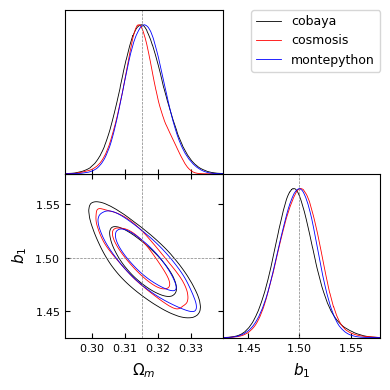

In [79]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_fs_cobaya, samples_bao_fs_cosmosis, samples_bao_fs_montepython],
                 params=['Omega_m', 'b1'], markers={'Omega_m': cosmo['Omega_m'], 'b1': 1.5})

# Wrap-up

- compressed or full-shape likelihoods are defined only once, within desilike
- bindings for Cobaya, CosmoSIS and MontePython are generated with a simple function call
- for Cobaya, the generated likelihood can be straightforwardly imported
- for CosmoSIS and MontePython, the description of nuisance parameters need be copied into the input config files